In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.ndimage import center_of_mass
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed
SEED = 42
np.random.seed(SEED)

print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load dataset
data = np.load('dataset_dev_3000.npz')
X = data['X']
y = data['y']

print(f"Input X shape: {X.shape}")
print(f"Targets y shape: {y.shape}")
print(f"\nTarget A (10-class): range [{y[:, 0].min():.0f}, {y[:, 0].max():.0f}]")
print(f"Target B (32-class): {len(np.unique(y[:, 1]))} classes, range [{y[:, 1].min():.0f}, {y[:, 1].max():.0f}]")
print(f"Target C (Regression): range [{y[:, 2].min():.4f}, {y[:, 2].max():.4f}]")

Input X shape: (3000, 32, 32)
Targets y shape: (3000, 3)

Target A (10-class): range [0, 9]
Target B (32-class): 32 classes, range [0, 31]
Target C (Regression): range [0.0003, 0.9996]


## 1. Visual Exploration of Images

IndexError: index 15 is out of bounds for axis 0 with size 15

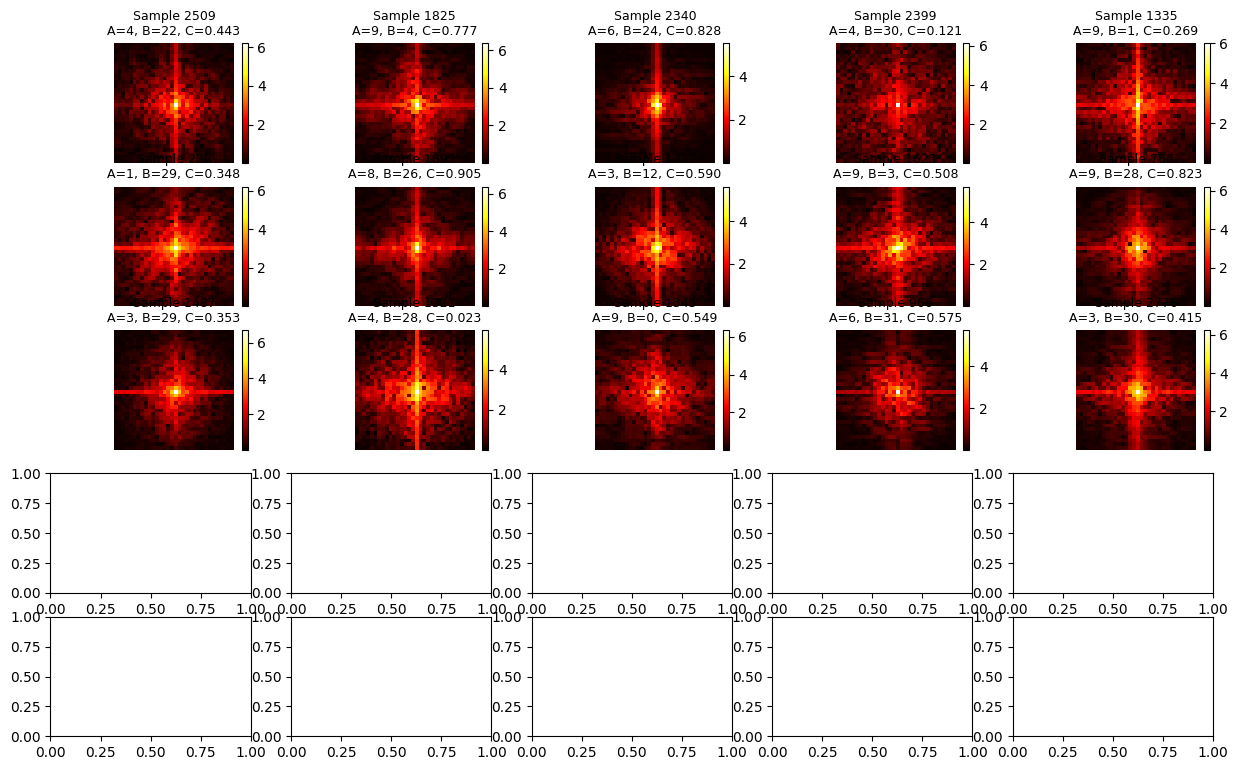

In [ ]:
# Visualize sample images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
sample_indices = np.random.choice(len(X), 15, replace=False)

for idx, ax in enumerate(axes.flat):
    sample_idx = sample_indices[idx]
    img = X[sample_idx].squeeze()
    
    im = ax.imshow(img, cmap='hot', interpolation='nearest')
    ax.set_title(f'Sample {sample_idx}\nA={int(y[sample_idx, 0])}, B={int(y[sample_idx, 1])}, C={y[sample_idx, 2]:.3f}', 
                 fontsize=9)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("✓ Sample images displayed")

In [4]:
# Plot line chart: Sample Index vs Target A values - Multiple views for pattern analysis
from scipy.ndimage import uniform_filter1d


def make_chart(target, numb, target_name):

    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # View 1: Raw progression with each class colored differently
    ax1 = axes[0]
    # target = y[:, 1]
    # numb = 32
    sample_indices = np.arange(len(target))
    
    # Color each class differently
    colors = plt.cm.tab10(np.arange(numb))
    for class_val in range(numb):
        mask = target == class_val
        ax1.scatter(
            sample_indices[mask],
            target[mask],
            c=[colors[class_val]],
            label=f"Class {class_val}",
            s=5,
            alpha=0.6,
        )

    ax1.set_xlabel("Sample Index", fontsize=11)
    ax1.set_ylabel(f"Target {target_name} Value", fontsize=11)
    ax1.set_title(
        f"Target {target_name}: Raw Progression (Colored by Class)", fontsize=13, fontweight="bold"
    )
    ax1.legend(ncol=numb, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, -0.1))
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-0.5, 9.5)

    # View 2: Line plot with rolling average to show trends
    ax2 = axes[1]
    ax2.plot(
        sample_indices,
        target,
        linewidth=0.5,
        alpha=0.3,
        color="lightgray",
        label="Raw values",
    )

    # Calculate rolling average with different window sizes
    window_sizes = [50, 100, 200]
    line_styles = ["-", "--", "-."]
    for window, style in zip(window_sizes, line_styles):
        smoothed = uniform_filter1d(target.astype(float), size=window, mode="nearest")
        ax2.plot(
            sample_indices,
            smoothed,
            linestyle=style,
            linewidth=2,
            label=f"Rolling avg (window={window})",
            alpha=0.8,
        )

    ax2.set_xlabel("Sample Index", fontsize=11)
    ax2.set_ylabel(f"Target {target_name} Value", fontsize=11)
    ax2.set_title(
        f"Target {target_name}: Progression with Rolling Averages (Pattern Detection)",
        fontsize=13,
        fontweight="bold",
    )
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # View 3: Class distribution over segments to see if there are clusters
    ax3 = axes[2]
    n_segments = 30
    segment_size = len(target) // n_segments
    segment_means = []
    segment_positions = []

    for i in range(n_segments):
        start_idx = i * segment_size
        end_idx = min((i + 1) * segment_size, len(target))
        segment_data = target[start_idx:end_idx]
        segment_means.append(np.mean(segment_data))
        segment_positions.append((start_idx + end_idx) / 2)

    ax3.plot(
        segment_positions,
        segment_means,
        marker="o",
        linewidth=2,
        markersize=6,
        color="darkblue",
    )
    ax3.fill_between(segment_positions, segment_means, alpha=0.3, color="lightblue")
    ax3.axhline(
        y=np.mean(target),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Overall mean = {np.mean(target):.2f}",
    )
    ax3.set_xlabel("Sample Index", fontsize=11)
    ax3.set_ylabel(f"Mean Target {target_name} Value", fontsize=11)
    ax3.set_title(
        f"Target {target_name}: Segmented Means ({n_segments} segments) - Shows Regional Patterns",
        fontsize=13,
        fontweight="bold",
    )
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

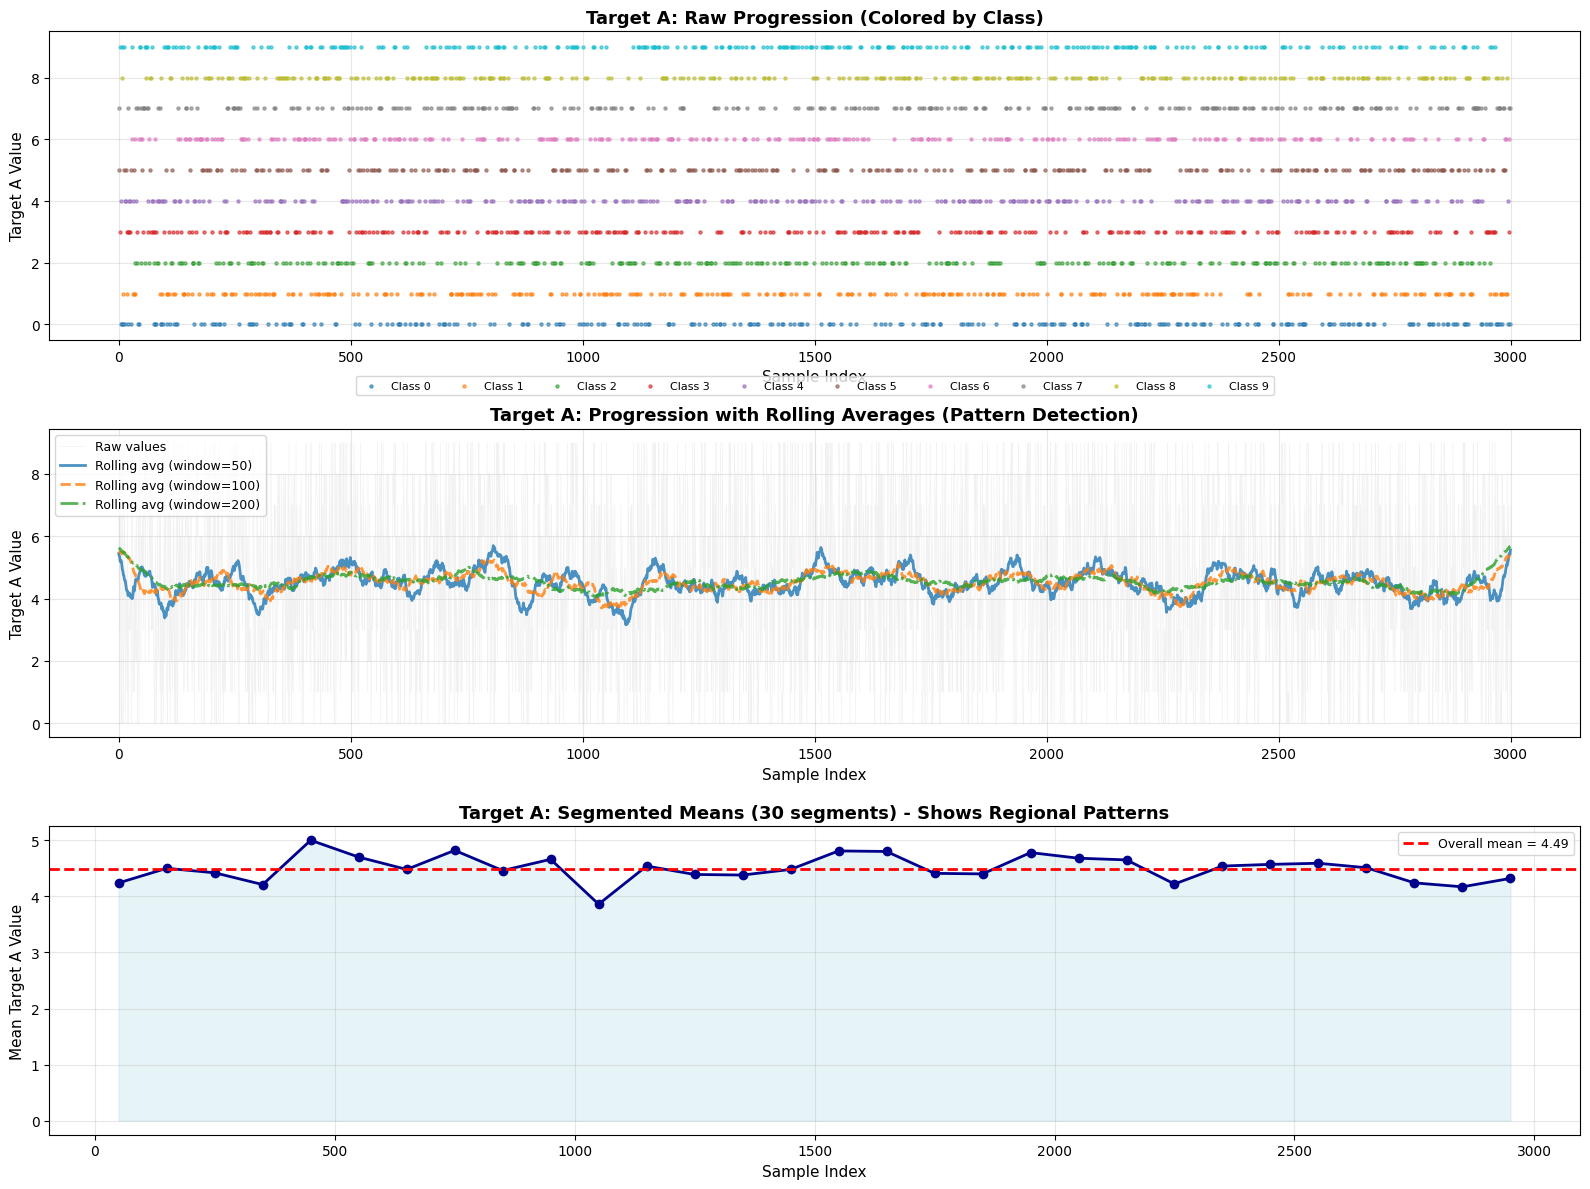

In [5]:
    # target = 
    # numb = 32
make_chart(y[:, 0], 10, "A")

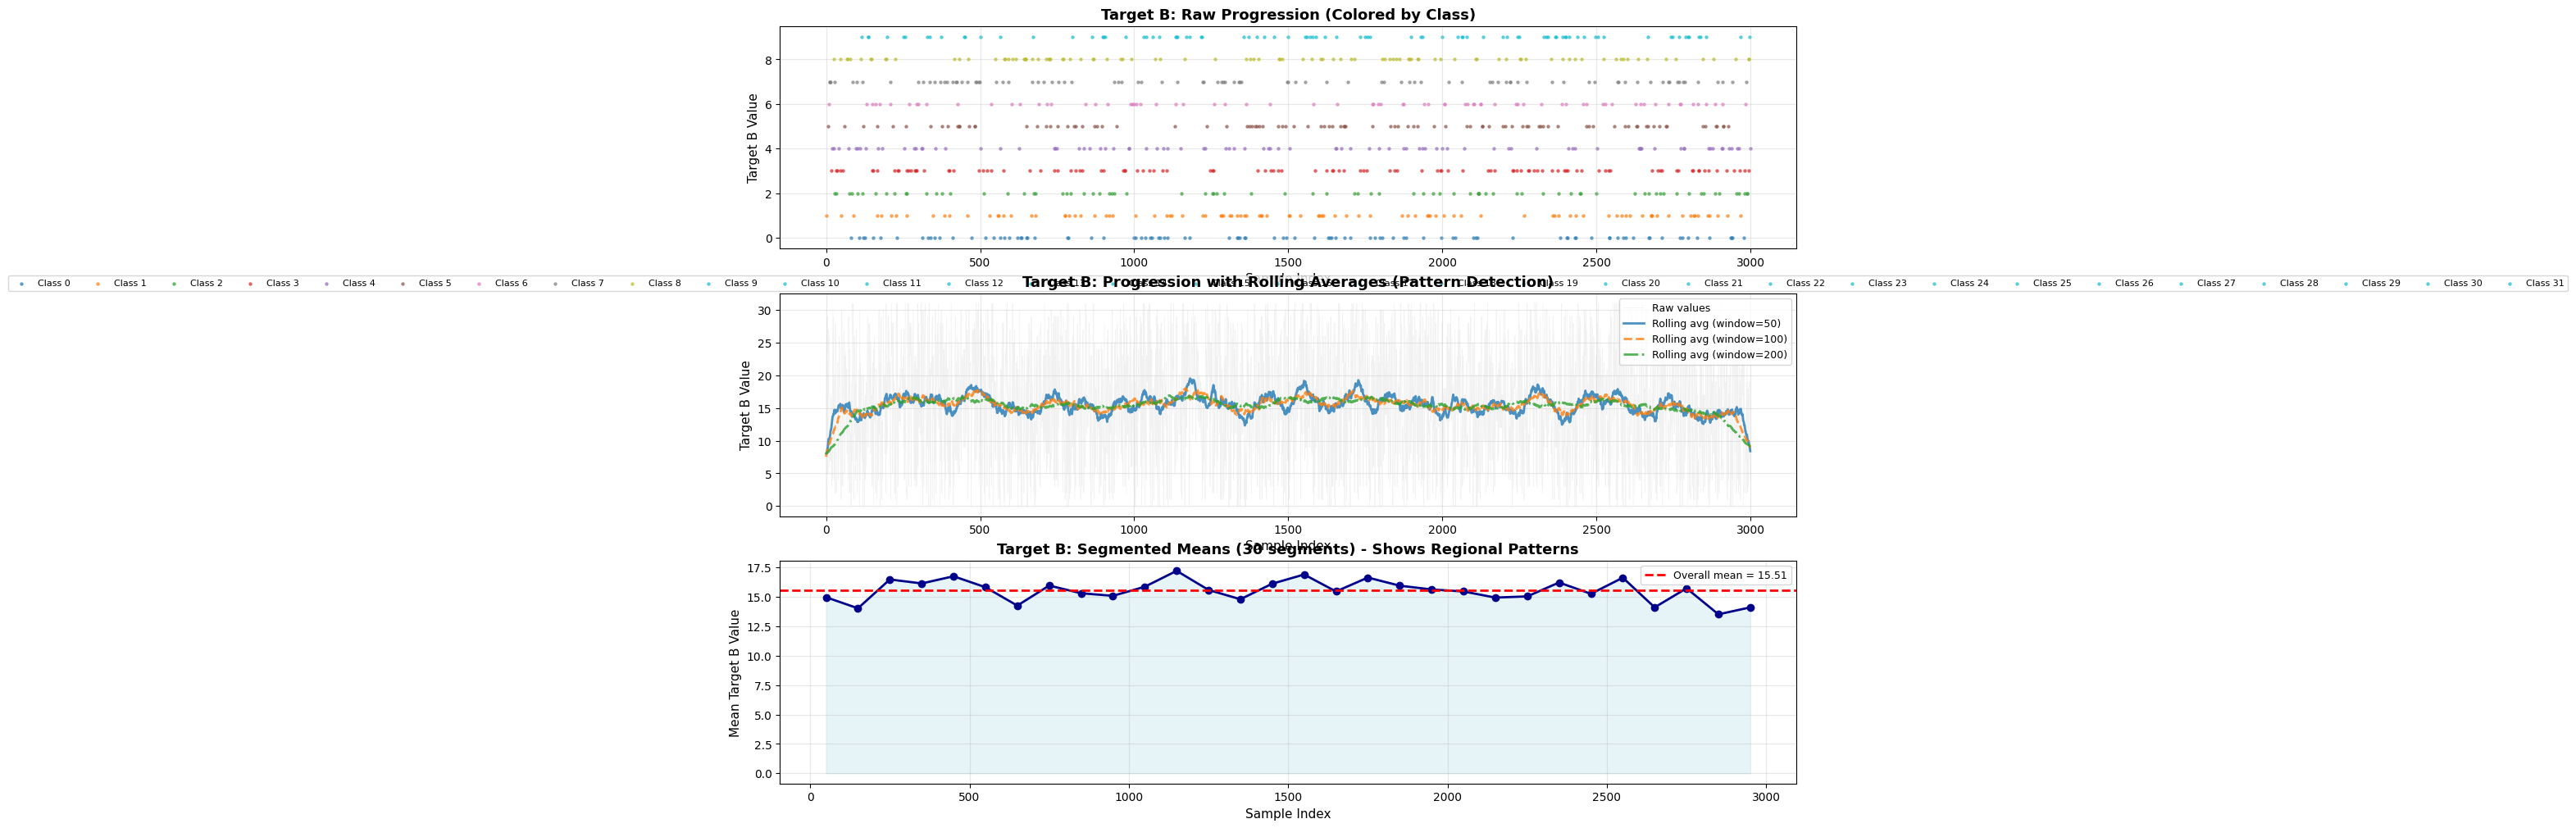

In [6]:
make_chart(y[:, 1], 32, "B")

## 2. FFT (Frequency Domain) Features

In [7]:
def extract_fft_features(images):
    """
    Extract FFT-based features from images:
    - FFT magnitude center of mass (x, y)
    - Total FFT energy
    - Dominant angle
    """
    features = {
        'fft_com_x': [],
        'fft_com_y': [],
        'fft_energy': [],
        'fft_dominant_angle': []
    }
    
    for img in images:
        img_2d = img.squeeze()
        
        # Apply 2D FFT
        fft = np.fft.fft2(img_2d)
        fft_shifted = np.fft.fftshift(fft)
        magnitude = np.abs(fft_shifted)
        
        # Center of mass of FFT magnitude
        com = center_of_mass(magnitude)
        features['fft_com_x'].append(com[0])
        features['fft_com_y'].append(com[1])
        
        # Total energy
        energy = np.sum(magnitude**2)
        features['fft_energy'].append(energy)
        
        # Dominant angle (from phase)
        phase = np.angle(fft_shifted)
        dominant_angle = np.mean(phase)
        features['fft_dominant_angle'].append(dominant_angle)
    
    # Convert to numpy arrays
    for key in features:
        features[key] = np.array(features[key])
    
    return features

print("Extracting FFT features...")
fft_features = extract_fft_features(X)
print("✓ FFT features extracted")
print(f"  Features: {list(fft_features.keys())}")

Extracting FFT features...
✓ FFT features extracted
  Features: ['fft_com_x', 'fft_com_y', 'fft_energy', 'fft_dominant_angle']


## 3. Spike/Peak Features

In [8]:
def extract_spike_features(images, threshold_percentile=90):
    """
    Extract spike/peak-based features:
    - Number of high peaks
    - Max spike value
    - Spike location (x, y)
    - Spike concentration (how concentrated are the peaks)
    """
    features = {
        'num_high_peaks': [],
        'max_spike_value': [],
        'spike_x': [],
        'spike_y': [],
        'spike_distance': [],  # Distance from center
        'peak_concentration': []  # Ratio of top 10% energy to total
    }
    
    for img in images:
        img_2d = img.squeeze()
        
        # Find peaks above threshold
        threshold = np.percentile(img_2d, threshold_percentile)
        peaks = img_2d > threshold
        num_peaks = np.sum(peaks)
        features['num_high_peaks'].append(num_peaks)
        
        # Max spike
        max_val = np.max(img_2d)
        features['max_spike_value'].append(max_val)
        
        # Location of max spike
        max_loc = np.unravel_index(np.argmax(img_2d), img_2d.shape)
        features['spike_x'].append(max_loc[0])
        features['spike_y'].append(max_loc[1])
        
        # Distance from center
        center = 16  # 32x32 image
        distance = np.sqrt((max_loc[0] - center)**2 + (max_loc[1] - center)**2)
        features['spike_distance'].append(distance)
        
        # Peak concentration
        flat = img_2d.flatten()
        sorted_vals = np.sort(flat)[::-1]
        top_10_percent = int(len(sorted_vals) * 0.1)
        concentration = np.sum(sorted_vals[:top_10_percent]) / np.sum(sorted_vals)
        features['peak_concentration'].append(concentration)
    
    # Convert to numpy arrays
    for key in features:
        features[key] = np.array(features[key])
    
    return features

print("Extracting spike/peak features...")
spike_features = extract_spike_features(X)
print("✓ Spike features extracted")
print(f"  Features: {list(spike_features.keys())}")

Extracting spike/peak features...
✓ Spike features extracted
  Features: ['num_high_peaks', 'max_spike_value', 'spike_x', 'spike_y', 'spike_distance', 'peak_concentration']


## 4. Geometric Features (Center of Mass, Symmetry, Radial)

In [9]:
def extract_geometric_features(images):
    """
    Extract geometric features based on visual observation:
    - Brightness toward center
    - Vertical and horizontal axis patterns
    - Radial intensity distribution
    """
    features = {
        'com_x': [],  # Center of mass X
        'com_y': [],  # Center of mass Y
        'com_distance': [],  # Distance from image center
        'central_intensity': [],  # Mean intensity in central region
        'vertical_profile': [],  # Std of vertical projection
        'horizontal_profile': [],  # Std of horizontal projection
        'radial_mean': [],  # Mean radial intensity
        'radial_std': [],  # Std of radial intensity
        'symmetry_v': [],  # Vertical symmetry (correlation between left/right halves)
        'symmetry_h': []  # Horizontal symmetry (correlation between top/bottom halves)
    }
    
    center = 16  # 32x32 image center
    
    for img in images:
        img_2d = img.squeeze()
        
        # Center of mass (weighted by intensity)
        com = center_of_mass(img_2d)
        features['com_x'].append(com[0])
        features['com_y'].append(com[1])
        
        # Distance from image center
        com_dist = np.sqrt((com[0] - center)**2 + (com[1] - center)**2)
        features['com_distance'].append(com_dist)
        
        # Central region intensity (5x5 center)
        central_region = img_2d[14:19, 14:19]
        features['central_intensity'].append(np.mean(central_region))
        
        # Vertical and horizontal profiles (variation along axes)
        vertical_proj = np.mean(img_2d, axis=1)  # Average along rows
        horizontal_proj = np.mean(img_2d, axis=0)  # Average along columns
        features['vertical_profile'].append(np.std(vertical_proj))
        features['horizontal_profile'].append(np.std(horizontal_proj))
        
        # Radial intensity profile (from center)
        y_coords, x_coords = np.meshgrid(np.arange(32), np.arange(32))
        distances = np.sqrt((x_coords - center)**2 + (y_coords - center)**2)
        
        # Compute radial profile in 8 bins
        radial_values = []
        for r_min, r_max in [(0, 4), (4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32)]:
            mask = (distances >= r_min) & (distances < r_max)
            if np.any(mask):
                radial_values.append(np.mean(img_2d[mask]))
        
        features['radial_mean'].append(np.mean(radial_values))
        features['radial_std'].append(np.std(radial_values))
        
        # Symmetry measures
        # Vertical symmetry: correlation between left and right halves
        left_half = img_2d[:, :16]
        right_half = np.fliplr(img_2d[:, 16:])
        sym_v = np.corrcoef(left_half.flatten(), right_half.flatten())[0, 1]
        features['symmetry_v'].append(sym_v if not np.isnan(sym_v) else 0)
        
        # Horizontal symmetry: correlation between top and bottom halves
        top_half = img_2d[:16, :]
        bottom_half = np.flipud(img_2d[16:, :])
        sym_h = np.corrcoef(top_half.flatten(), bottom_half.flatten())[0, 1]
        features['symmetry_h'].append(sym_h if not np.isnan(sym_h) else 0)
    
    # Convert to numpy arrays
    for key in features:
        features[key] = np.array(features[key])
    
    return features

print("Extracting geometric features...")
geometric_features = extract_geometric_features(X)
print("✓ Geometric features extracted")
print(f"  Features: {list(geometric_features.keys())}")

Extracting geometric features...
✓ Geometric features extracted
  Features: ['com_x', 'com_y', 'com_distance', 'central_intensity', 'vertical_profile', 'horizontal_profile', 'radial_mean', 'radial_std', 'symmetry_v', 'symmetry_h']


## 5. Statistical Features

In [10]:
def extract_statistical_features(images):
    """
    Extract basic statistical features:
    - Mean, std, min, max intensity
    - Skewness, kurtosis
    - Entropy
    """
    features = {
        'mean_intensity': [],
        'std_intensity': [],
        'min_intensity': [],
        'max_intensity': [],
        'skewness': [],
        'kurtosis': [],
        'entropy': []
    }
    
    for img in images:
        img_flat = img.flatten()
        
        features['mean_intensity'].append(np.mean(img_flat))
        features['std_intensity'].append(np.std(img_flat))
        features['min_intensity'].append(np.min(img_flat))
        features['max_intensity'].append(np.max(img_flat))
        features['skewness'].append(stats.skew(img_flat))
        features['kurtosis'].append(stats.kurtosis(img_flat))
        
        # Entropy (information content)
        hist, _ = np.histogram(img_flat, bins=50, density=True)
        hist = hist[hist > 0]  # Remove zeros
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        features['entropy'].append(entropy)
    
    # Convert to numpy arrays
    for key in features:
        features[key] = np.array(features[key])
    
    return features

print("Extracting statistical features...")
stat_features = extract_statistical_features(X)
print("✓ Statistical features extracted")
print(f"  Features: {list(stat_features.keys())}")

Extracting statistical features...
✓ Statistical features extracted
  Features: ['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'skewness', 'kurtosis', 'entropy']


## 6. Correlation Analysis: All Features vs All Targets

In [11]:
def analyze_correlations(features_dict, targets, target_names):
    """
    Compute Pearson and Spearman correlations between all features and all targets
    """
    results = []
    
    for target_idx, target_name in enumerate(target_names):
        target_values = targets[:, target_idx]
        
        for feature_name, feature_values in features_dict.items():
            # Pearson correlation
            pearson_corr, pearson_p = stats.pearsonr(feature_values, target_values)
            
            # Spearman correlation
            spearman_corr, spearman_p = stats.spearmanr(feature_values, target_values)
            
            results.append({
                'target': target_name,
                'feature': feature_name,
                'pearson_r': pearson_corr,
                'pearson_p': pearson_p,
                'spearman_r': spearman_corr,
                'spearman_p': spearman_p,
                'abs_spearman': abs(spearman_corr)
            })
    
    return results

# Combine all features
all_features = {}
all_features.update(fft_features)
all_features.update(spike_features)
all_features.update(geometric_features)
all_features.update(stat_features)

print(f"Total features extracted: {len(all_features)}")
print("\nComputing correlations...")

target_names = ['Target A (10-class)', 'Target B (32-class)', 'Target C (Regression)']
correlation_results = analyze_correlations(all_features, y, target_names)

print("✓ Correlation analysis complete")

Total features extracted: 27

Computing correlations...
✓ Correlation analysis complete


## 7. Display Top Correlations for Each Target

In [12]:
import pandas as pd

# Convert to DataFrame for easier analysis
df_corr = pd.DataFrame(correlation_results)

print("="*100)
print("TOP 10 FEATURES BY ABSOLUTE SPEARMAN CORRELATION")
print("="*100)

for target_name in target_names:
    print(f"\n{target_name}")
    print("-"*100)
    
    target_df = df_corr[df_corr['target'] == target_name].sort_values('abs_spearman', ascending=False).head(10)
    
    for idx, row in target_df.iterrows():
        print(f"  {row['feature']:<30} | Spearman: {row['spearman_r']:>7.4f} (p={row['spearman_p']:.2e}) | "
              f"Pearson: {row['pearson_r']:>7.4f} (p={row['pearson_p']:.2e})")

print("\n" + "="*100)

TOP 10 FEATURES BY ABSOLUTE SPEARMAN CORRELATION

Target A (10-class)
----------------------------------------------------------------------------------------------------
  vertical_profile               | Spearman:  0.1537 (p=2.52e-17) | Pearson:  0.1555 (p=1.08e-17)
  entropy                        | Spearman:  0.1365 (p=5.86e-14) | Pearson:  0.1265 (p=3.62e-12)
  std_intensity                  | Spearman:  0.1345 (p=1.38e-13) | Pearson:  0.1340 (p=1.73e-13)
  symmetry_h                     | Spearman:  0.1336 (p=2.06e-13) | Pearson:  0.1316 (p=4.55e-13)
  fft_energy                     | Spearman:  0.1317 (p=4.35e-13) | Pearson:  0.1336 (p=2.02e-13)
  kurtosis                       | Spearman: -0.1274 (p=2.51e-12) | Pearson: -0.1185 (p=7.45e-11)
  radial_mean                    | Spearman:  0.1209 (p=3.12e-11) | Pearson:  0.1195 (p=5.13e-11)
  mean_intensity                 | Spearman:  0.1184 (p=7.76e-11) | Pearson:  0.1181 (p=8.70e-11)
  skewness                       | Spearman: 

## 8. Visualize Top Correlations

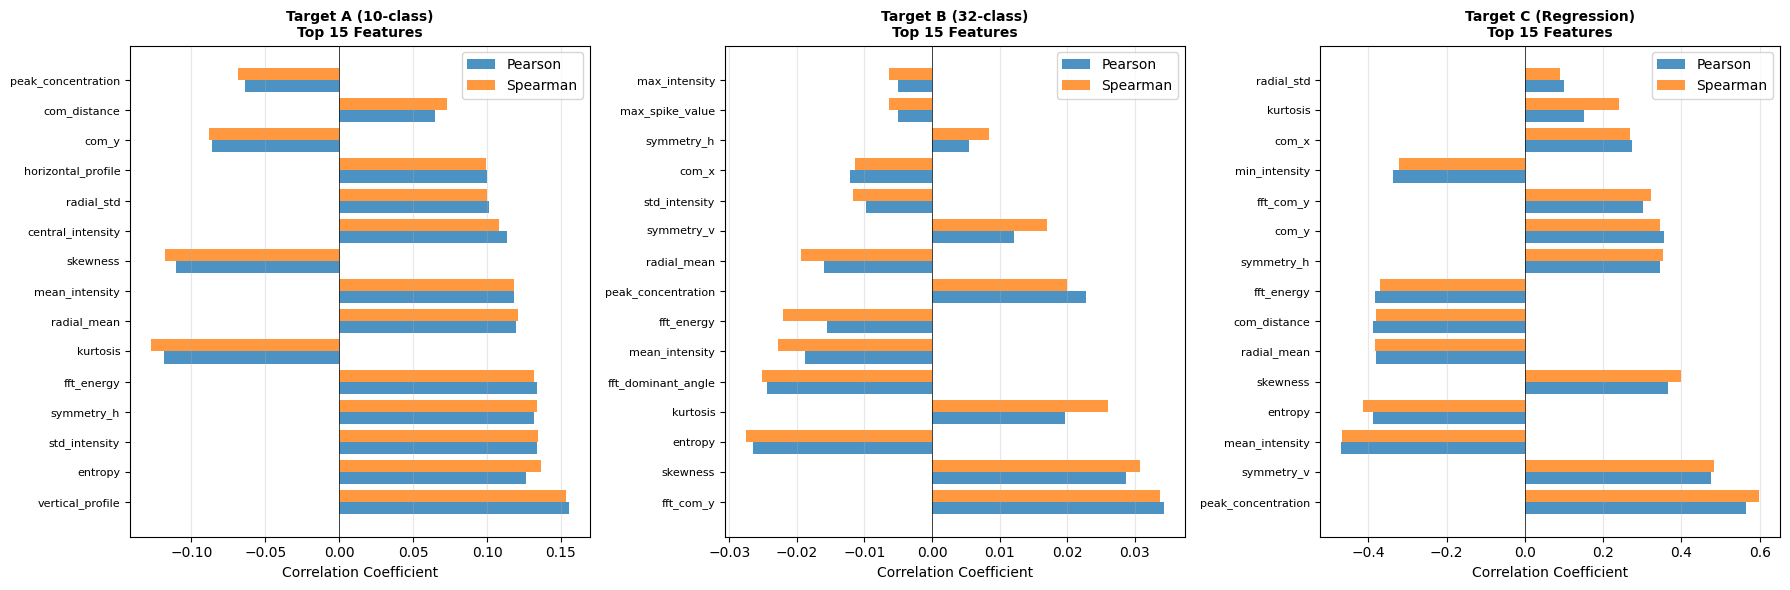

✓ Correlation visualization complete


In [13]:
# Create heatmap of top features for each target
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (target_name, ax) in enumerate(zip(target_names, axes)):
    target_df = df_corr[df_corr['target'] == target_name].sort_values('abs_spearman', ascending=False).head(15)
    
    # Create data for heatmap
    features = target_df['feature'].values
    pearson_vals = target_df['pearson_r'].values
    spearman_vals = target_df['spearman_r'].values
    
    # Plot
    y_pos = np.arange(len(features))
    
    ax.barh(y_pos - 0.2, pearson_vals, 0.4, label='Pearson', alpha=0.8)
    ax.barh(y_pos + 0.2, spearman_vals, 0.4, label='Spearman', alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features, fontsize=8)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title(f'{target_name}\nTop 15 Features', fontsize=10, fontweight='bold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    ax.axvline(x=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("✓ Correlation visualization complete")

## 9. Scatter Plots: Top Features vs Targets

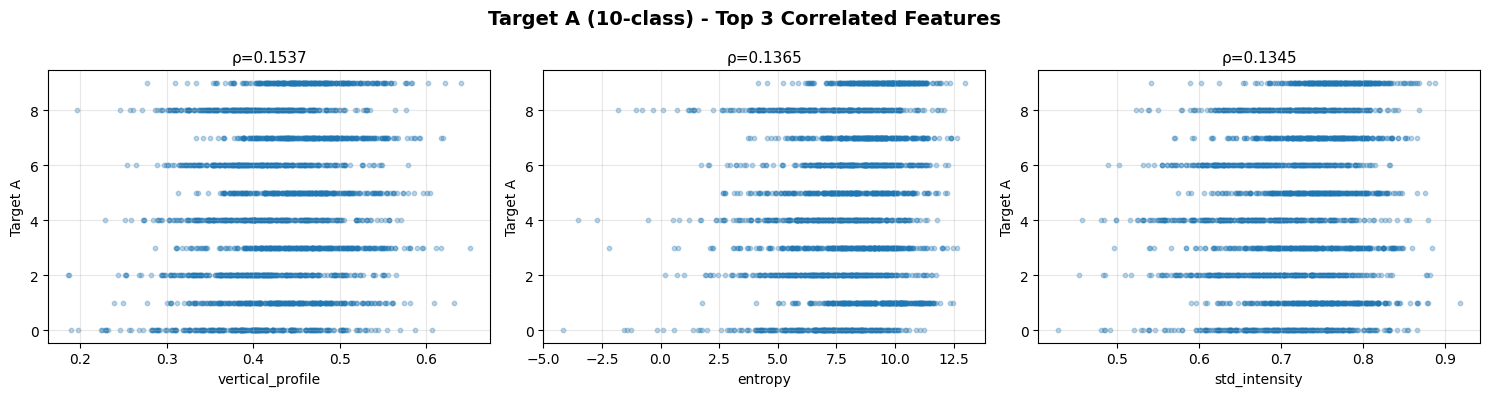

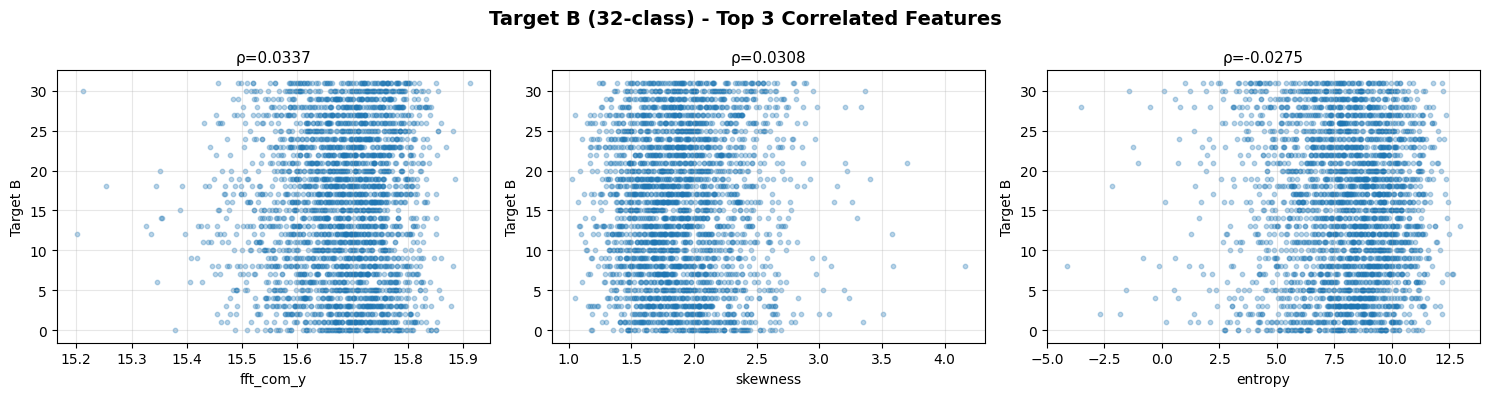

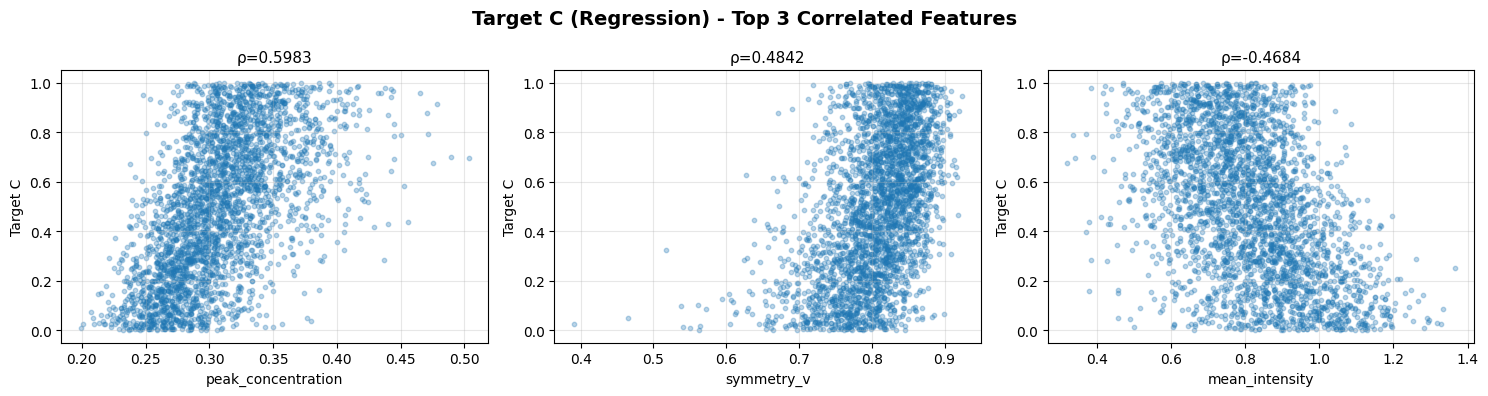

✓ Scatter plots complete


In [14]:
# For each target, plot top 3 features
for target_idx, target_name in enumerate(target_names):
    target_df = df_corr[df_corr['target'] == target_name].sort_values('abs_spearman', ascending=False).head(3)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'{target_name} - Top 3 Correlated Features', fontsize=14, fontweight='bold')
    
    for idx, (_, row) in enumerate(target_df.iterrows()):
        feature_name = row['feature']
        feature_values = all_features[feature_name]
        target_values = y[:, target_idx]
        
        axes[idx].scatter(feature_values, target_values, alpha=0.3, s=10)
        axes[idx].set_xlabel(feature_name, fontsize=10)
        axes[idx].set_ylabel(target_name.split('(')[0].strip(), fontsize=10)
        axes[idx].set_title(f"ρ={row['spearman_r']:.4f}", fontsize=11)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Scatter plots complete")

## 10. Feature Category Summary

In [15]:
# Categorize features
def categorize_feature(feature_name):
    if 'fft' in feature_name.lower():
        return 'FFT/Frequency'
    elif any(x in feature_name.lower() for x in ['spike', 'peak', 'num_high']):
        return 'Spike/Peak'
    elif any(x in feature_name.lower() for x in ['com', 'central', 'symmetry', 'radial', 'vertical', 'horizontal']):
        return 'Geometric'
    else:
        return 'Statistical'

df_corr['category'] = df_corr['feature'].apply(categorize_feature)

print("="*100)
print("BEST FEATURE CATEGORY BY TARGET")
print("="*100)

for target_name in target_names:
    print(f"\n{target_name}")
    print("-"*100)
    
    target_df = df_corr[df_corr['target'] == target_name]
    
    category_stats = target_df.groupby('category').agg({
        'abs_spearman': ['mean', 'max', 'count']
    }).round(4)
    
    category_stats.columns = ['Mean |ρ|', 'Max |ρ|', 'Count']
    category_stats = category_stats.sort_values('Max |ρ|', ascending=False)
    
    print(category_stats)
    
    # Show best feature from each category
    print("\n  Best feature from each category:")
    for category in category_stats.index:
        best = target_df[target_df['category'] == category].sort_values('abs_spearman', ascending=False).iloc[0]
        print(f"    {category:<20}: {best['feature']:<30} (ρ={best['spearman_r']:>7.4f})")

print("\n" + "="*100)

BEST FEATURE CATEGORY BY TARGET

Target A (10-class)
----------------------------------------------------------------------------------------------------
               Mean |ρ|  Max |ρ|  Count
category                               
Geometric        0.0952   0.1537     10
Statistical      0.0948   0.1365      7
FFT/Frequency    0.0582   0.1317      4
Spike/Peak       0.0340   0.0685      3

  Best feature from each category:
    Geometric           : vertical_profile               (ρ= 0.1537)
    Statistical         : entropy                        (ρ= 0.1365)
    FFT/Frequency       : fft_energy                     (ρ= 0.1317)
    Spike/Peak          : peak_concentration             (ρ=-0.0685)

Target B (32-class)
----------------------------------------------------------------------------------------------------
               Mean |ρ|  Max |ρ|  Count
category                               
FFT/Frequency    0.0212   0.0337      4
Statistical      0.0182   0.0308      7
Spike/Peak  

## 11. Key Insights Summary

In [16]:
print("="*100)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*100)

for target_idx, target_name in enumerate(target_names):
    print(f"\n{target_name}")
    print("-"*100)
    
    target_df = df_corr[df_corr['target'] == target_name].sort_values('abs_spearman', ascending=False)
    
    # Get top correlations
    top_feature = target_df.iloc[0]
    max_corr = top_feature['abs_spearman']
    
    if max_corr > 0.4:
        strength = "STRONG"
        emoji = "🎯"
    elif max_corr > 0.2:
        strength = "MODERATE"
        emoji = "📊"
    elif max_corr > 0.1:
        strength = "WEAK"
        emoji = "📉"
    else:
        strength = "VERY WEAK"
        emoji = "❌"
    
    print(f"  {emoji} Correlation Strength: {strength} (max |ρ|={max_corr:.4f})")
    print(f"  🏆 Best feature: {top_feature['feature']} (ρ={top_feature['spearman_r']:.4f})")
    
    # Category analysis
    category_means = target_df.groupby('category')['abs_spearman'].mean().sort_values(ascending=False)
    best_category = category_means.index[0]
    print(f"  📂 Best category: {best_category} (avg |ρ|={category_means.iloc[0]:.4f})")
    
    # Recommendation
    if max_corr < 0.1:
        print(f"  💡 Recommendation: Hand-crafted features insufficient. Use deep learning (CNN).")
    elif max_corr < 0.3:
        print(f"  💡 Recommendation: Combine best features with CNN for hybrid approach.")
    else:
        print(f"  💡 Recommendation: {best_category} features are highly predictive. Can use directly or combine with CNN.")

print("\n" + "="*100)
print("✓ Analysis complete!")
print("="*100)

KEY INSIGHTS & RECOMMENDATIONS

Target A (10-class)
----------------------------------------------------------------------------------------------------
  📉 Correlation Strength: WEAK (max |ρ|=0.1537)
  🏆 Best feature: vertical_profile (ρ=0.1537)
  📂 Best category: Geometric (avg |ρ|=0.0952)
  💡 Recommendation: Combine best features with CNN for hybrid approach.

Target B (32-class)
----------------------------------------------------------------------------------------------------
  ❌ Correlation Strength: VERY WEAK (max |ρ|=0.0337)
  🏆 Best feature: fft_com_y (ρ=0.0337)
  📂 Best category: FFT/Frequency (avg |ρ|=0.0212)
  💡 Recommendation: Hand-crafted features insufficient. Use deep learning (CNN).

Target C (Regression)
----------------------------------------------------------------------------------------------------
  🎯 Correlation Strength: STRONG (max |ρ|=0.5983)
  🏆 Best feature: peak_concentration (ρ=0.5983)
  📂 Best category: Statistical (avg |ρ|=0.2715)
  💡 Recommendation: 

## 12. Export Feature Matrix for Model Training

In [17]:
# Create feature matrix with top features for each target
def create_feature_matrix(top_n=10):
    """
    Create a feature matrix with top N features for each target
    """
    selected_features = set()
    
    for target_name in target_names:
        target_df = df_corr[df_corr['target'] == target_name].sort_values('abs_spearman', ascending=False).head(top_n)
        selected_features.update(target_df['feature'].values)
    
    print(f"Total unique features selected: {len(selected_features)}")
    
    # Create matrix
    feature_matrix = np.column_stack([all_features[f] for f in sorted(selected_features)])
    feature_names_list = sorted(selected_features)
    
    return feature_matrix, feature_names_list

feature_matrix, feature_names_list = create_feature_matrix(top_n=10)
print(f"\nFeature matrix shape: {feature_matrix.shape}")
print(f"\nSelected features:")
for i, name in enumerate(feature_names_list):
    print(f"  {i+1:2d}. {name}")

# Normalize features
scaler = StandardScaler()
feature_matrix_normalized = scaler.fit_transform(feature_matrix)

print(f"\n✓ Feature matrix ready for model training")
print(f"  Shape: {feature_matrix_normalized.shape}")
print(f"  Normalized: Yes (StandardScaler)")

Total unique features selected: 16

Feature matrix shape: (3000, 16)

Selected features:
   1. central_intensity
   2. com_distance
   3. com_y
   4. entropy
   5. fft_com_y
   6. fft_dominant_angle
   7. fft_energy
   8. kurtosis
   9. mean_intensity
  10. peak_concentration
  11. radial_mean
  12. skewness
  13. std_intensity
  14. symmetry_h
  15. symmetry_v
  16. vertical_profile

✓ Feature matrix ready for model training
  Shape: (3000, 16)
  Normalized: Yes (StandardScaler)


## 13. Cross-Task Prediction: Can Features Learned for C Predict A/B?

In [18]:
# Import necessary libraries for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set random seeds
tf.random.set_seed(SEED)

print("Deep learning libraries imported")
print(f"TensorFlow version: {tf.__version__}")

Deep learning libraries imported
TensorFlow version: 2.16.1


In [19]:
# Prepare data for deep learning
X_img = X[..., None].astype("float32")  # (N, 32, 32, 1)

# Extract targets
y_A = y[:, 0].astype("int32")  # 10-class
y_B = y[:, 1].astype("int32")  # 32-class
y_C = y[:, 2].astype("float32")  # regression

# Train/validation split (80/20)
X_train, X_val, y_A_train, y_A_val, y_B_train, y_B_val, y_C_train, y_C_val = train_test_split(
    X_img, y_A, y_B, y_C, 
    test_size=0.2, 
    random_state=SEED, 
    shuffle=True
)

# Normalize images
mean = X_train.mean()
std = X_train.std() + 1e-6
# X_train_norm = (X_train - mean) / std
# X_val_norm = (X_val - mean) / std

X_train_norm = X_train
X_val_norm = X_val

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Data normalized (mean={mean:.4f}, std={std:.4f})")

Training set: 2400 samples
Validation set: 600 samples
Data normalized (mean=0.8130, std=0.7384)


In [20]:
# Build a simple CNN for Target C (Regression)
def build_cnn_for_C():
    """
    Simple CNN for regression on Target C
    Includes a latent layer for feature extraction
    """
    inputs = layers.Input(shape=(32, 32, 1), name="img")
    
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu", name="latent")(x)  # This is the feature layer
    
    outputs = layers.Dense(1, activation="sigmoid", name="C")(x)
    
    return models.Model(inputs, outputs, name="CNN_for_C")

model_C = build_cnn_for_C()
model_C.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

print("Model for Target C built:")
model_C.summary()

Model for Target C built:


Model: "CNN_for_C"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C (Dense)                       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,409 (474.25 KB)

 Trainable params: 121,409 (474.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model on Target C
print("Training CNN on Target C (Regression)...")
print("="*60)

history_C = model_C.fit(
    X_train_norm,
    y_C_train,
    validation_data=(X_val_norm, y_C_val),
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate on validation set
val_loss, val_mae = model_C.evaluate(X_val_norm, y_C_val, verbose=0)
print("\n" + "="*60)
print(f"Target C Validation Results:")
print(f"  MSE Loss: {val_loss:.4f}")
print(f"  MAE:      {val_mae:.4f}")
print("="*60)

Training CNN on Target C (Regression)...
Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0570 - mae: 0.1950 - val_loss: 0.0365 - val_mae: 0.1546
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0309 - mae: 0.1414 - val_loss: 0.0258 - val_mae: 0.1266
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0218 - mae: 0.1184 - val_loss: 0.0235 - val_mae: 0.1198
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0179 - mae: 0.1075 - val_loss: 0.0200 - val_mae: 0.1111
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0165 - mae: 0.1028 - val_loss: 0.0171 - val_mae: 0.1030
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0153 - mae: 0.0988 - val_loss: 0.0165 - val_mae: 0.1014
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - mae: 0.0992 - val_loss: 0.0166 - val_mae: 0.1001
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0141 - mae: 0.0951 - val_loss: 0.0175 - val_mae: 0.1025
Epoch 9/25
75/75 ━━━━━━━━━━━━

In [22]:
# Extract features from the latent layer
print("Extracting latent features from C model...")

feature_extractor = models.Model(
    inputs=model_C.input,
    outputs=model_C.get_layer("latent").output
)

Z_train = feature_extractor.predict(X_train_norm, verbose=0)
Z_val = feature_extractor.predict(X_val_norm, verbose=0)

print(f"✓ Latent features extracted")
print(f"  Training features shape: {Z_train.shape}")
print(f"  Validation features shape: {Z_val.shape}")
print(f"  Feature dimension: {Z_train.shape[1]}")

Extracting latent features from C model...
✓ Latent features extracted
  Training features shape: (2400, 64)
  Validation features shape: (600, 64)
  Feature dimension: 64


### 13.1 Test: Can C-learned features predict Target A (10-class)?

In [23]:
# Train classifiers on Z features to predict Target A
print("="*80)
print("CROSS-TASK PREDICTION: C Features → Target A (10-class)")
print("="*80)

classifiers_A = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "SVM (Linear)": SVC(kernel='linear', random_state=SEED)
}

results_A = {}

for clf_name, clf in classifiers_A.items():
    print(f"\n{clf_name}:")
    print("-"*80)
    
    # Train
    clf.fit(Z_train, y_A_train)
    
    # Predict
    y_A_pred_train = clf.predict(Z_train)
    y_A_pred_val = clf.predict(Z_val)
    
    # Accuracies
    train_acc = accuracy_score(y_A_train, y_A_pred_train)
    val_acc = accuracy_score(y_A_val, y_A_pred_val)
    
    results_A[clf_name] = {
        'train_acc': train_acc,
        'val_acc': val_acc
    }
    
    print(f"  Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Random Baseline:     {1/10:.4f} (10.00%)")
    
    # Show classification report for validation set
    if val_acc > 0.15:  # Only show if better than random
        print(f"\n  Classification Report (Validation):")
        report = classification_report(y_A_val, y_A_pred_val, zero_division=0)
        for line in report.split('\n'):
            if line.strip():
                print(f"    {line}")

print("\n" + "="*80)
print("SUMMARY: C Features → Target A")
print("="*80)
for clf_name, res in results_A.items():
    print(f"{clf_name:<25}: Val Acc = {res['val_acc']:.4f} ({res['val_acc']*100:.2f}%)")
print("="*80)

CROSS-TASK PREDICTION: C Features → Target A (10-class)

Logistic Regression:
--------------------------------------------------------------------------------
  Training Accuracy:   0.2571 (25.71%)
  Validation Accuracy: 0.2183 (21.83%)
  Random Baseline:     0.1000 (10.00%)

  Classification Report (Validation):
                  precision    recall  f1-score   support
               0       0.28      0.25      0.26        53
               1       0.24      0.20      0.22        66
               2       0.17      0.32      0.23        50
               3       0.14      0.15      0.14        55
               4       0.15      0.12      0.13        67
               5       0.21      0.16      0.18        56
               6       0.19      0.25      0.21        60
               7       0.34      0.18      0.23        74
               8       0.32      0.43      0.36        54
               9       0.21      0.20      0.20        65
        accuracy                           0.22

### 13.2 Test: Can C-learned features predict Target B (32-class)?

In [24]:
# Train classifiers on Z features to predict Target B
print("="*80)
print("CROSS-TASK PREDICTION: C Features → Target B (32-class)")
print("="*80)

classifiers_B = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=SEED),
    "SVM (Linear)": SVC(kernel='linear', random_state=SEED)
}

results_B = {}

for clf_name, clf in classifiers_B.items():
    print(f"\n{clf_name}:")
    print("-"*80)
    
    # Train
    clf.fit(Z_train, y_B_train)
    
    # Predict
    y_B_pred_train = clf.predict(Z_train)
    y_B_pred_val = clf.predict(Z_val)
    
    # Accuracies
    train_acc = accuracy_score(y_B_train, y_B_pred_train)
    val_acc = accuracy_score(y_B_val, y_B_pred_val)
    
    results_B[clf_name] = {
        'train_acc': train_acc,
        'val_acc': val_acc
    }
    
    print(f"  Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Random Baseline:     {1/32:.4f} (3.12%)")

print("\n" + "="*80)
print("SUMMARY: C Features → Target B")
print("="*80)
for clf_name, res in results_B.items():
    print(f"{clf_name:<25}: Val Acc = {res['val_acc']:.4f} ({res['val_acc']*100:.2f}%)")
print("="*80)

CROSS-TASK PREDICTION: C Features → Target B (32-class)

Logistic Regression:
--------------------------------------------------------------------------------
  Training Accuracy:   0.1029 (10.29%)
  Validation Accuracy: 0.0500 (5.00%)
  Random Baseline:     0.0312 (3.12%)

Random Forest:
--------------------------------------------------------------------------------
  Training Accuracy:   1.0000 (100.00%)
  Validation Accuracy: 0.0517 (5.17%)
  Random Baseline:     0.0312 (3.12%)

SVM (Linear):
--------------------------------------------------------------------------------
  Training Accuracy:   0.0950 (9.50%)
  Validation Accuracy: 0.0517 (5.17%)
  Random Baseline:     0.0312 (3.12%)

SUMMARY: C Features → Target B
Logistic Regression      : Val Acc = 0.0500 (5.00%)
Random Forest            : Val Acc = 0.0517 (5.17%)
SVM (Linear)             : Val Acc = 0.0517 (5.17%)


### 13.3 Visualization: Cross-Task Prediction Performance

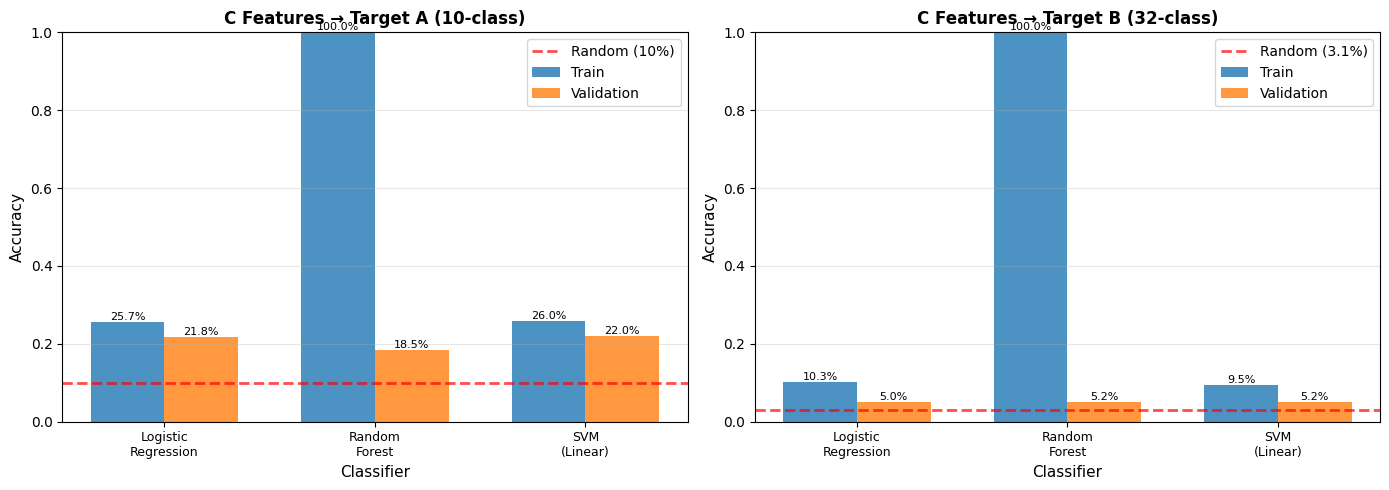

✓ Cross-task prediction visualization complete


In [25]:
# Visualize cross-task prediction results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Target A
ax1 = axes[0]
clf_names = list(results_A.keys())
val_accs_A = [results_A[name]['val_acc'] for name in clf_names]
train_accs_A = [results_A[name]['train_acc'] for name in clf_names]

x_pos = np.arange(len(clf_names))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, train_accs_A, width, label='Train', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, val_accs_A, width, label='Validation', alpha=0.8)

ax1.axhline(y=1/10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (10%)')
ax1.set_xlabel('Classifier', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('C Features → Target A (10-class)', fontsize=12, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([name.replace(' ', '\n') for name in clf_names], fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom', fontsize=8)

# Plot for Target B
ax2 = axes[1]
val_accs_B = [results_B[name]['val_acc'] for name in clf_names]
train_accs_B = [results_B[name]['train_acc'] for name in clf_names]

bars3 = ax2.bar(x_pos - width/2, train_accs_B, width, label='Train', alpha=0.8)
bars4 = ax2.bar(x_pos + width/2, val_accs_B, width, label='Validation', alpha=0.8)

ax2.axhline(y=1/32, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (3.1%)')
ax2.set_xlabel('Classifier', fontsize=11)
ax2.set_ylabel('Accuracy', fontsize=11)
ax2.set_title('C Features → Target B (32-class)', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([name.replace(' ', '\n') for name in clf_names], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Cross-task prediction visualization complete")

### 13.4 Key Findings: Cross-Task Transfer from C

In [26]:
# Analyze and summarize the cross-task transfer results
print("="*80)
print("KEY FINDINGS: Can Features Learned for C Predict A and B?")
print("="*80)

# Get best validation accuracies
best_A_clf = max(results_A.items(), key=lambda x: x[1]['val_acc'])
best_B_clf = max(results_B.items(), key=lambda x: x[1]['val_acc'])

print(f"\n📊 TARGET A (10-class classification)")
print("-"*80)
print(f"  Best Classifier: {best_A_clf[0]}")
print(f"  Validation Accuracy: {best_A_clf[1]['val_acc']:.4f} ({best_A_clf[1]['val_acc']*100:.2f}%)")
print(f"  Random Baseline: 0.1000 (10.00%)")
print(f"  Improvement over random: {(best_A_clf[1]['val_acc'] - 0.1) / 0.1 * 100:.1f}%")

if best_A_clf[1]['val_acc'] > 0.3:
    verdict_A = "✅ STRONG TRANSFER - C features are highly predictive of A"
elif best_A_clf[1]['val_acc'] > 0.2:
    verdict_A = "⚠️ MODERATE TRANSFER - C features have some predictive power for A"
elif best_A_clf[1]['val_acc'] > 0.15:
    verdict_A = "📉 WEAK TRANSFER - C features show limited predictive power for A"
else:
    verdict_A = "❌ NO TRANSFER - C features cannot predict A better than random"

print(f"\n  {verdict_A}")

print(f"\n📊 TARGET B (32-class classification)")
print("-"*80)
print(f"  Best Classifier: {best_B_clf[0]}")
print(f"  Validation Accuracy: {best_B_clf[1]['val_acc']:.4f} ({best_B_clf[1]['val_acc']*100:.2f}%)")
print(f"  Random Baseline: 0.0312 (3.12%)")
print(f"  Improvement over random: {(best_B_clf[1]['val_acc'] - 0.0312) / 0.0312 * 100:.1f}%")

if best_B_clf[1]['val_acc'] > 0.2:
    verdict_B = "✅ STRONG TRANSFER - C features are highly predictive of B"
elif best_B_clf[1]['val_acc'] > 0.1:
    verdict_B = "⚠️ MODERATE TRANSFER - C features have some predictive power for B"
elif best_B_clf[1]['val_acc'] > 0.05:
    verdict_B = "📉 WEAK TRANSFER - C features show limited predictive power for B"
else:
    verdict_B = "❌ NO TRANSFER - C features cannot predict B better than random"

print(f"\n  {verdict_B}")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

avg_improvement_A = (best_A_clf[1]['val_acc'] - 0.1) / 0.1 * 100
avg_improvement_B = (best_B_clf[1]['val_acc'] - 0.0312) / 0.0312 * 100

if avg_improvement_A > 50 and avg_improvement_B > 100:
    conclusion = """
✅ Features learned for Target C CAN predict both A and B significantly better 
   than random, suggesting strong shared structure between all three tasks.
   
💡 RECOMMENDATION: Use multi-task learning! Training on C can help learn 
   representations useful for A and B.
"""
elif avg_improvement_A > 20 or avg_improvement_B > 50:
    conclusion = """
⚠️ Features learned for Target C show PARTIAL transfer to A and/or B.
   There is some shared structure, but task-specific features are also important.
   
💡 RECOMMENDATION: Consider multi-task learning with task-specific branches.
"""
else:
    conclusion = """
❌ Features learned for Target C show MINIMAL transfer to A and B.
   The tasks may require different representations.
   
💡 RECOMMENDATION: Train separate models or use very different architectures 
   for different tasks.
"""

print(conclusion)
print("="*80)

KEY FINDINGS: Can Features Learned for C Predict A and B?

📊 TARGET A (10-class classification)
--------------------------------------------------------------------------------
  Best Classifier: SVM (Linear)
  Validation Accuracy: 0.2200 (22.00%)
  Random Baseline: 0.1000 (10.00%)
  Improvement over random: 120.0%

  ⚠️ MODERATE TRANSFER - C features have some predictive power for A

📊 TARGET B (32-class classification)
--------------------------------------------------------------------------------
  Best Classifier: Random Forest
  Validation Accuracy: 0.0517 (5.17%)
  Random Baseline: 0.0312 (3.12%)
  Improvement over random: 65.6%

  📉 WEAK TRANSFER - C features show limited predictive power for B

CONCLUSION

⚠️ Features learned for Target C show PARTIAL transfer to A and/or B.
   There is some shared structure, but task-specific features are also important.

💡 RECOMMENDATION: Consider multi-task learning with task-specific branches.



## 14. Baseline: CNN Trained on A + Logistic Regression

In [27]:
# Build a simple CNN for Target A (10-class classification)
def build_cnn_for_A():
    """
    Simple CNN for 10-class classification on Target A
    Includes a latent layer for feature extraction
    """
    inputs = layers.Input(shape=(32, 32, 1), name="img")
    
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu", name="latent_A")(x)  # Feature layer for A
    
    outputs = layers.Dense(10, activation="softmax", name="A")(x)
    
    return models.Model(inputs, outputs, name="CNN_for_A")

model_A = build_cnn_for_A()
model_A.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model for Target A built:")
model_A.summary()

Model for Target A built:


Model: "CNN_for_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_A (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ A (Dense)                       │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,994 (476.54 KB)

 Trainable params: 121,994 (476.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train the CNN on Target A
print("Training CNN on Target A (10-class classification)...")
print("="*60)

history_A = model_A.fit(
    X_train_norm,
    y_A_train,
    validation_data=(X_val_norm, y_A_val),
    epochs=25,
    batch_size=32,
    verbose=1
)

# Evaluate on validation set
val_loss, val_acc = model_A.evaluate(X_val_norm, y_A_val, verbose=0)
print("\n" + "="*60)
print(f"Target A Validation Results (Direct CNN):")
print(f"  Loss:     {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  Random baseline: {1/10:.4f} (10.00%)")
print("="*60)

Training CNN on Target A (10-class classification)...
Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1471 - loss: 2.2861 - val_accuracy: 0.1050 - val_loss: 2.3085
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1775 - loss: 2.2059 - val_accuracy: 0.1717 - val_loss: 2.1982
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2329 - loss: 2.0973 - val_accuracy: 0.2200 - val_loss: 2.0818
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2887 - loss: 1.9659 - val_accuracy: 0.2733 - val_loss: 1.9884
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3333 - loss: 1.8617 - val_accuracy: 0.2917 - val_loss: 1.9297
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3638 - loss: 1.7914 - val_accuracy: 0.3183 - val_loss: 1.9234
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3887 - loss: 1.7188 - val_accuracy: 0.3333 - val_loss: 1.9049
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 

In [29]:
# Extract features from the latent layer of the A model
print("Extracting latent features from A model...")

feature_extractor_A = models.Model(
    inputs=model_A.input,
    outputs=model_A.get_layer("latent_A").output
)

Z_A_train = feature_extractor_A.predict(X_train_norm, verbose=0)
Z_A_val = feature_extractor_A.predict(X_val_norm, verbose=0)

print(f"✓ Latent features extracted from A model")
print(f"  Training features shape: {Z_A_train.shape}")
print(f"  Validation features shape: {Z_A_val.shape}")
print(f"  Feature dimension: {Z_A_train.shape[1]}")

Extracting latent features from A model...
✓ Latent features extracted from A model
  Training features shape: (2400, 64)
  Validation features shape: (600, 64)
  Feature dimension: 64


In [30]:
# Test: Logistic Regression on A-learned features to predict A
print("="*80)
print("BASELINE TEST: A Features → Target A (using Logistic Regression)")
print("="*80)

# Train logistic regression on features learned by CNN for A
lr_on_A_features = LogisticRegression(max_iter=1000, random_state=SEED)
lr_on_A_features.fit(Z_A_train, y_A_train)

# Predict
y_A_pred_train_lr = lr_on_A_features.predict(Z_A_train)
y_A_pred_val_lr = lr_on_A_features.predict(Z_A_val)

# Accuracies
train_acc_lr = accuracy_score(y_A_train, y_A_pred_train_lr)
val_acc_lr = accuracy_score(y_A_val, y_A_pred_val_lr)

print(f"\nLogistic Regression on A-learned features:")
print("-"*80)
print(f"  Training Accuracy:   {train_acc_lr:.4f} ({train_acc_lr*100:.2f}%)")
print(f"  Validation Accuracy: {val_acc_lr:.4f} ({val_acc_lr*100:.2f}%)")
print(f"  Random Baseline:     {1/10:.4f} (10.00%)")

print(f"\nComparison with Direct CNN:")
print("-"*80)
print(f"  Direct CNN (softmax):        {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  LogReg on CNN features:      {val_acc_lr:.4f} ({val_acc_lr*100:.2f}%)")
print(f"  Difference:                  {(val_acc_lr - val_acc):.4f} ({(val_acc_lr - val_acc)*100:.2f}%)")

if val_acc_lr >= val_acc - 0.02:
    interpretation = "✅ Logistic regression performs comparably to the full CNN softmax layer"
elif val_acc_lr >= val_acc - 0.05:
    interpretation = "⚠️ Logistic regression performs slightly worse than the full CNN"
else:
    interpretation = "❌ Logistic regression performs significantly worse than the full CNN"

print(f"\n{interpretation}")

print("\n" + "="*80)
print("Classification Report (Logistic Regression on A features):")
print("="*80)
report = classification_report(y_A_val, y_A_pred_val_lr, zero_division=0)
print(report)
print("="*80)

BASELINE TEST: A Features → Target A (using Logistic Regression)

Logistic Regression on A-learned features:
--------------------------------------------------------------------------------
  Training Accuracy:   0.8467 (84.67%)
  Validation Accuracy: 0.3317 (33.17%)
  Random Baseline:     0.1000 (10.00%)

Comparison with Direct CNN:
--------------------------------------------------------------------------------
  Direct CNN (softmax):        0.2850 (28.50%)
  LogReg on CNN features:      0.3317 (33.17%)
  Difference:                  0.0467 (4.67%)

✅ Logistic regression performs comparably to the full CNN softmax layer

Classification Report (Logistic Regression on A features):
              precision    recall  f1-score   support

           0       0.32      0.28      0.30        53
           1       0.40      0.52      0.45        66
           2       0.26      0.32      0.29        50
           3       0.26      0.25      0.26        55
           4       0.27      0.25      

### 14.1 Comparison: C-learned vs A-learned features for predicting A

In [31]:
# Compare C-learned features vs A-learned features for predicting A
print("="*80)
print("FEATURE TRANSFER COMPARISON: Predicting Target A")
print("="*80)

# Get the best result from C features → A (from section 13.1)
best_C_to_A_acc = results_A["Logistic Regression"]['val_acc']

print(f"\n1️⃣ Features learned from Target C (regression):")
print(f"   Logistic Regression Accuracy: {best_C_to_A_acc:.4f} ({best_C_to_A_acc*100:.2f}%)")

print(f"\n2️⃣ Features learned from Target A (direct task):")
print(f"   Logistic Regression Accuracy: {val_acc_lr:.4f} ({val_acc_lr*100:.2f}%)")

print(f"\n3️⃣ Direct CNN prediction on Target A:")
print(f"   Softmax Layer Accuracy:       {val_acc:.4f} ({val_acc*100:.2f}%)")

print(f"\n" + "-"*80)
print(f"INSIGHTS:")
print("-"*80)

# Calculate performance gaps
gap_C_vs_A = val_acc_lr - best_C_to_A_acc
gap_lr_vs_cnn = val_acc - val_acc_lr

print(f"Gap: A-features vs C-features:  {gap_C_vs_A:+.4f} ({gap_C_vs_A*100:+.2f}%)")
print(f"Gap: CNN-softmax vs LogReg:     {gap_lr_vs_cnn:+.4f} ({gap_lr_vs_cnn*100:+.2f}%)")

if gap_C_vs_A < 0.05:
    insight_1 = "✅ C-learned features transfer WELL to A! Shared representations exist."
elif gap_C_vs_A < 0.15:
    insight_1 = "⚠️ C-learned features transfer PARTIALLY to A. Some sharing, but task-specific features help."
else:
    insight_1 = "❌ C-learned features transfer POORLY to A. Tasks require different representations."

if abs(gap_lr_vs_cnn) < 0.02:
    insight_2 = "✅ Logistic regression on CNN features is as good as the CNN's softmax layer!"
elif abs(gap_lr_vs_cnn) < 0.05:
    insight_2 = "⚠️ Logistic regression is slightly worse than the CNN's softmax layer."
else:
    insight_2 = "❌ Logistic regression significantly underperforms the CNN's softmax layer."

print(f"\n{insight_1}")
print(f"{insight_2}")
print("\n" + "="*80)

FEATURE TRANSFER COMPARISON: Predicting Target A

1️⃣ Features learned from Target C (regression):
   Logistic Regression Accuracy: 0.2183 (21.83%)

2️⃣ Features learned from Target A (direct task):
   Logistic Regression Accuracy: 0.3317 (33.17%)

3️⃣ Direct CNN prediction on Target A:
   Softmax Layer Accuracy:       0.2850 (28.50%)

--------------------------------------------------------------------------------
INSIGHTS:
--------------------------------------------------------------------------------
Gap: A-features vs C-features:  +0.1133 (+11.33%)
Gap: CNN-softmax vs LogReg:     -0.0467 (-4.67%)

⚠️ C-learned features transfer PARTIALLY to A. Some sharing, but task-specific features help.
⚠️ Logistic regression is slightly worse than the CNN's softmax layer.



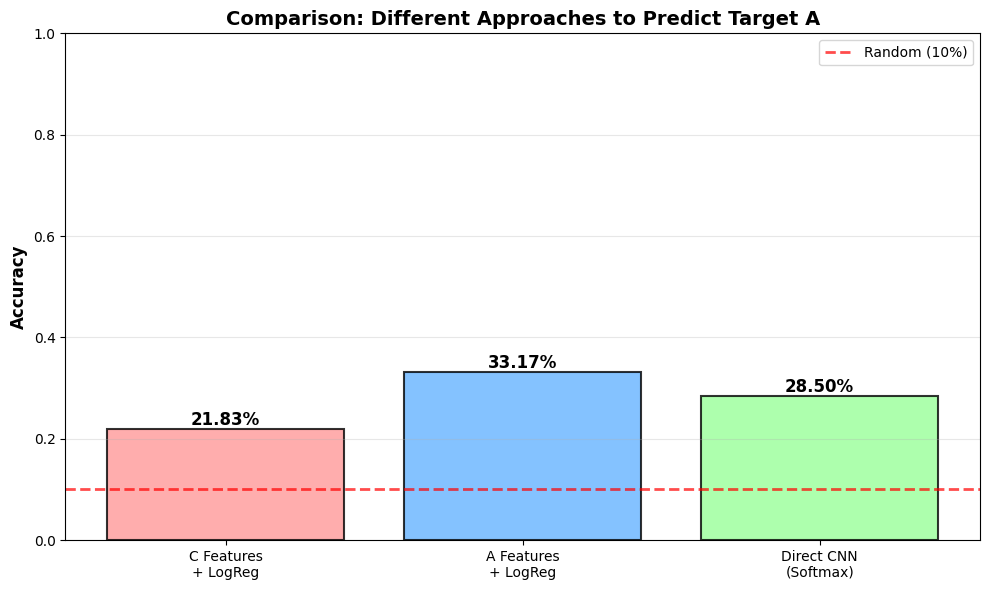

✓ Comparison visualization complete


In [32]:
# Visualize the comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

methods = ['C Features\n+ LogReg', 'A Features\n+ LogReg', 'Direct CNN\n(Softmax)']
accuracies = [best_C_to_A_acc, val_acc_lr, val_acc]
colors = ['#ff9999', '#66b3ff', '#99ff99']

bars = ax.bar(methods, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add random baseline line
ax.axhline(y=0.1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Random (10%)')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Comparison: Different Approaches to Predict Target A', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Comparison visualization complete")